# PyTorch Basics

I'll assume that everyone is familiar with python. Training neural nets in bare python is somewhat painful, but fortunately there are several well-established libraries which can help. I like pytorch, which is built upon an earlier library called torch. There are many others, including TensorFlow and Jax.

In [1]:
# We start by importing the libraries we'll use today
import numpy as np
import torch
import torchvision

Torch believes everything is a *tensor.*

In [2]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

print(a)
print(b)

[[0.8072397  0.73888739 0.84167864]
 [0.59699655 0.39603503 0.62348274]]
tensor([[0.8072, 0.7389, 0.8417],
        [0.5970, 0.3960, 0.6235]], dtype=torch.float64)


The main intuition is that tensors allow for intuitive and efficient matrix multiplication across different indexing dimensions. Soon, we will see that training neural nets basically consits of *forward* and *backward* passes, both of which are essentially matrix multiplies.

The other thing about torch variables is that they (natively) can be differentiated. Again, we'll see why this is important when we learn about backpropagation.

In [5]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad = True)

y = torch.matmul(A, x) + b

print(y)

tensor([[1.6698],
        [0.9769]], grad_fn=<AddBackward0>)


In [6]:
z = y.sum()
print(z)

tensor(2.6467, grad_fn=<SumBackward0>)


Here, $z$ is a function of the input $x$. Let us now compute the derivative of $z$ with respect to $x$ using backpropagation.

In [7]:
z.backward()
print(x.grad)
print(x)

tensor([[1.7956],
        [0.4061]])
tensor([[0.8103],
        [0.4738]], requires_grad=True)


## Training simple models

Let's jump in with our first, simple model. We will train a logistic classifier (equivalent to using a single-layer neural network) on a popular image dataset called *Fashion-MNIST*. Torchvision also has several other image datasets which we can directly load as variables.

In [8]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



Let's check that everything has been downloaded.

In [9]:
print(len(trainingdata))
print(len(testdata))

60000
10000


Let's investigate to see what's inside the dataset.

In [10]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


We cannot directly plot the image object since it is a tensor. So we'll convert it back into a numpy array before displaying it with matplotlib.

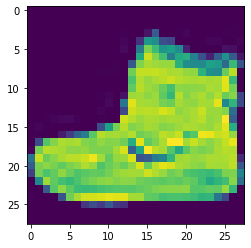

In [11]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze().numpy())
plt.show()

Looks like a shoe? Fashion-MNIST is a bunch of different black and white images of clothing with a corresponding label identifying the category the clothing belongs to. It looks like label 9 corresponds to shoes.

In order to nicely wrap the process of iterating through the dataset, we'll use a dataloader.

In [12]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

Now let's use it to look at a few images.

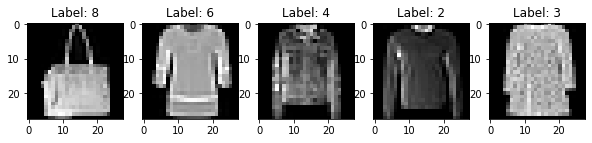

In [17]:
images, labels = next(iter(trainDataLoader))

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.title(f'Label: {labels[index].item()}')
  plt.imshow(images[index].squeeze().numpy(),cmap=plt.cm.gray)

In [20]:
images[0].view(-1,28*28).shape

torch.Size([1, 784])

Now let's set up our model.

In [21]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28, 10)
  
  def forward(self, x):
    x = x.view(-1, 28*28) # change so 784 vector instead of 28x28 matrix
    return self.linear(x)

model = LinearReg() # Step 1: architecture
loss = torch.nn.CrossEntropyLoss() # Step 2: loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Step 3: training method

Now let's train our model!

In [25]:
train_loss_history = []
test_loss_history = []

for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    optimizer.zero_grad()
    predicted_output = model(images)
    fit = loss(predicted_output, labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item() / len(trainingdata)
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      predicted_output = model(images)
      fit = loss(predicted_output, labels)
      test_loss += fit.item() / len(testdata)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')
    

Epoch 0, Train loss 0.009460963308811179, Test loss 0.009491513538360594
Epoch 1, Train loss 0.008906421000758804, Test loss 0.009089281973242758
Epoch 2, Train loss 0.008543276670575136, Test loss 0.008829532244801513
Epoch 3, Train loss 0.00828337795784076, Test loss 0.008642805424332616
Epoch 4, Train loss 0.008080825527012338, Test loss 0.008422688958048815
Epoch 5, Train loss 0.007917426279187203, Test loss 0.008290799459815024
Epoch 6, Train loss 0.007787001544237129, Test loss 0.00817347337305546
Epoch 7, Train loss 0.0076712499275803595, Test loss 0.008094488829374314
Epoch 8, Train loss 0.0075817159990469556, Test loss 0.008012965819239614
Epoch 9, Train loss 0.007498361700276533, Test loss 0.00794834821522236
Epoch 10, Train loss 0.0074222053614755494, Test loss 0.007874941056966785
Epoch 11, Train loss 0.007354242742806679, Test loss 0.007840061458945276
Epoch 12, Train loss 0.007294412394116326, Test loss 0.007786454555392263
Epoch 13, Train loss 0.007238737463951114, Test 

Let's plot our loss by training epoch to see how we did.

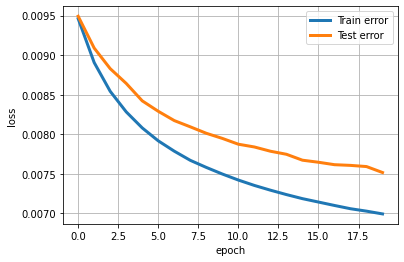

In [27]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

Why is test loss larger than training loss?

We definitely see some improvement. Let's look at the images, the predictions our model makes and the true label.

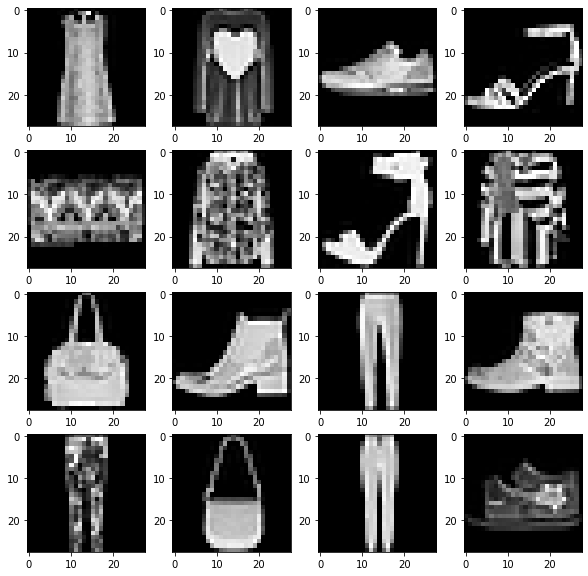

In [28]:
plt.figure(figsize=(10,10))
for index in np.arange(0,16):
  plt.subplot(4,4,index+1)
  plt.imshow(images[index].cpu().squeeze().numpy(),cmap=plt.cm.gray)

Now for the labels and predicted labels.

In [36]:
predicted_output = model(images)
print('Predicted:', torch.max(predicted_output, 1)[1])
fit = loss(predicted_output, labels)
print('True labels:', labels)
print(fit.item()/ len(labels))

Predicted: tensor([3, 1, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5])
True labels: tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5])
0.020091092213988304
